# Проект: Статистический анализ данных

**Вы аналитик популярного сервиса аренды самокатов GoFast. Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:**
1. без подписки
   - абонентская плата отсутствует;
   - стоимость одной минуты поездки — 8 рублей;
   - стоимость старта (начала поездки) — 50 рублей;
2. с подпиской Ultra
   - абонентская плата — 199 рублей в месяц;
   - стоимость одной минуты поездки — 6 рублей;
   - стоимость старта — бесплатно.


In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt 

In [3]:
from math import factorial

In [4]:
import numpy as np

In [5]:
from scipy import stats as st

#### Шаг 1. Загрузка данных

##### Считайте CSV-файлы с данными с помощью библиотеки pandas и сохраните их в датафреймы

In [6]:
try:
    users = pd.read_csv('/datasets/users_go.csv', sep = ',')
except:
    users = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv', sep=',')

In [7]:
try:
    rides = pd.read_csv('/datasets/rides_go.csv', sep = ',')
except:
    rides = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv', sep=',')

In [8]:
try:
    subscriptions = pd.read_csv('/datasets/subscriptions_go.csv', sep = ',')
except:
    subscriptions = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv', sep=',')

##### Выведите первые строки каждого набора данных. Изучите общую информацию о каждом датафрейме.

In [9]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [10]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [11]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [12]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [13]:
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [14]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


***Вывод:*** У нас имеется три таблицы с данными. У таблыцы users 1565 стрики и 5 столбцов. У таблицы rides имеется 18068 строк и 4 столбца. В таблице subscriptions 2 строки и 4 столбца. Пропусков в данных не замечено. Так же имеется общий клюк для таблицы users и rides это user_id, а для таблиц users и subscriptions - subscription_type.

#### Шаг 2. Предобработка данных

##### Приведите столбец date к типу даты pandas.

In [15]:
rides['date'] = pd.to_datetime(rides.date)

In [16]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


##### Создайте новый столбец с номером месяца на основе столбца date.

In [17]:
rides['month'] = pd.to_datetime(rides["date"]).dt.month

In [18]:
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


##### Проверьте наличие пропущенных значений и дубликатов в датафреймах. Обработайте их, если такие значения присутствуют.


In [19]:
users.duplicated().sum() #имеются явные дубликаты. Удалим их

31

In [20]:
users = users.drop_duplicates().reset_index(drop = True)
users

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
...,...,...,...,...,...
1529,1530,Ростислав,29,Сочи,free
1530,1531,Никита,25,Пятигорск,free
1531,1532,Алексей,26,Тюмень,free
1532,1533,Степан,22,Краснодар,free


In [21]:
rides.duplicated().sum() #дубликатов не замечено или они неявные

0

In [22]:
subscriptions.duplicated().sum() #дубликатов не замечено или они неявные

0

In [23]:
pd.DataFrame(round(users.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
user_id,0.000000
name,0.000000
age,0.000000
city,0.000000
subscription_type,0.000000


In [24]:
pd.DataFrame(round(rides.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
user_id,0.000000
distance,0.000000
duration,0.000000
date,0.000000
month,0.000000


In [25]:
pd.DataFrame(round(subscriptions.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
subscription_type,0.000000
minute_price,0.000000
start_ride_price,0.000000
subscription_fee,0.000000


***Вывод:*** Привели столбец date к типу даты pandas. Создали новый столбец с номером месяца. Так же обработали явные дубликаты в таблице users. Пропусков в трех таблицах не было замеченно.

#### Шаг 3. Исследовательский анализ данных

##### Частота встречаемости городов

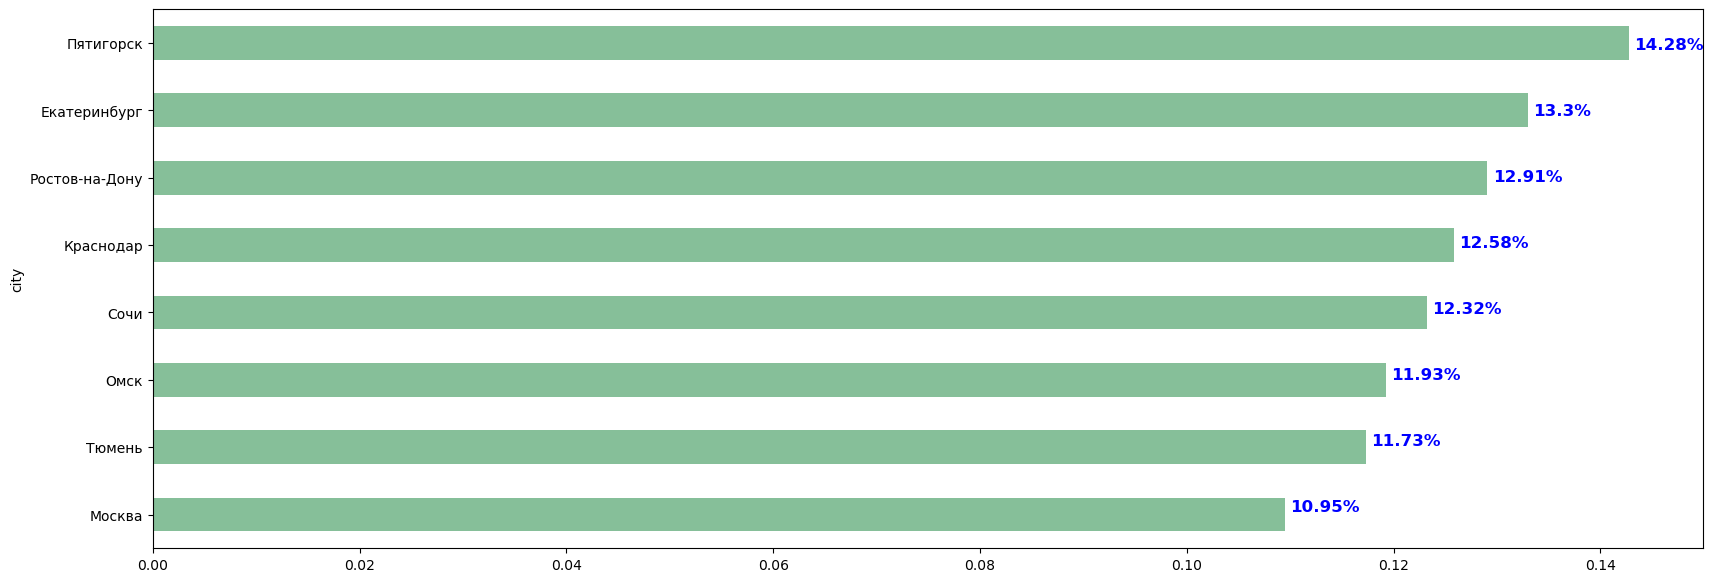

In [26]:
t = users.groupby('city').size()/len(users['user_id'])
t = t.sort_values()
ax = t.plot(kind='barh', color='#86bf99', figsize=(20,7))

labels = dict(t)
labels

i = 0
for city in labels:
    ax.text(labels[city] + 0.0005, i + 0.05, str(round(labels[city]*100, 2)) + '%', 
            fontsize = 'large', fontweight='bold', color='blue')
    if i < 9.7:
        i += 0.98
    else:
        i += 1.02

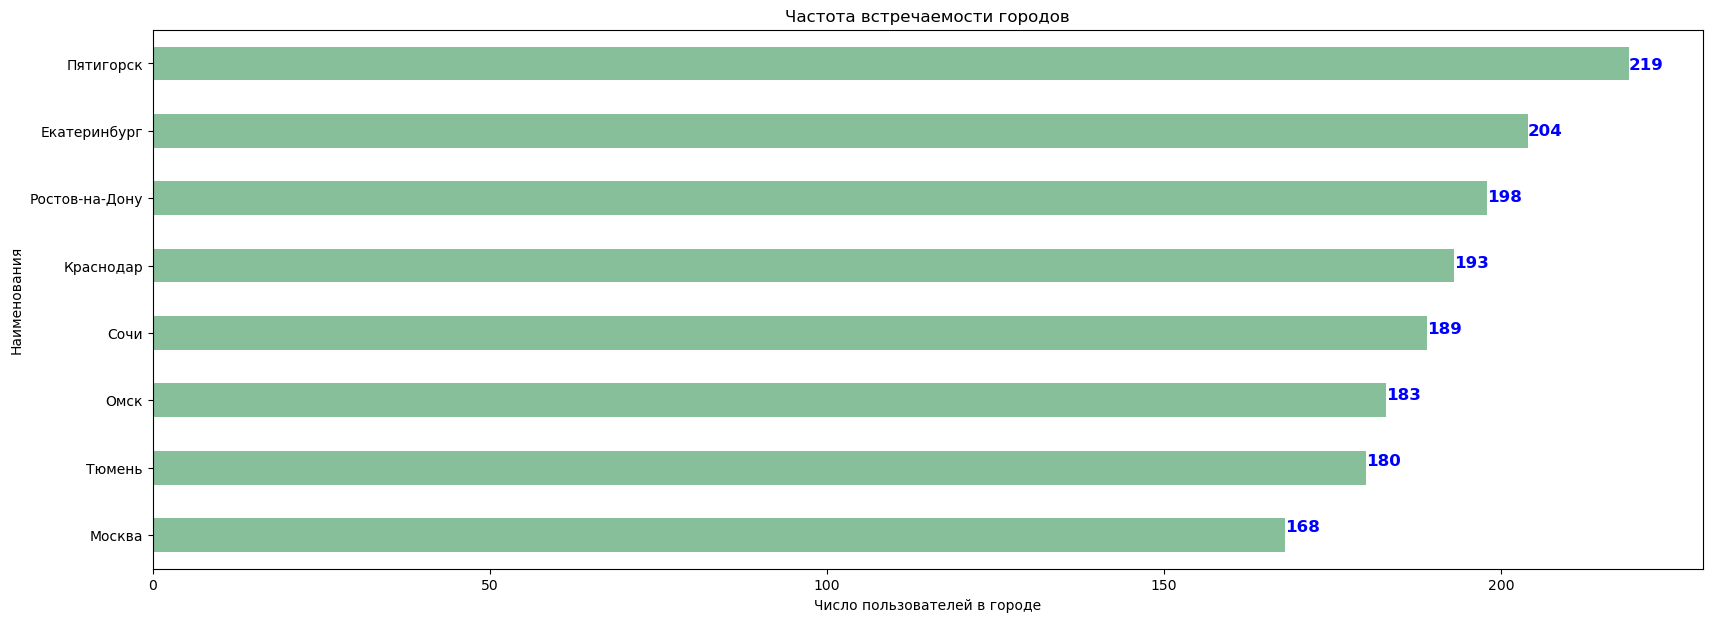

In [27]:
t = users['city'].value_counts()
t = t.sort_values()
ax = t.plot(kind='barh', color='#86bf99', figsize=(20,7))
plt.title("Частота встречаемости городов")
plt.xlabel("Число пользователей в городе")
plt.ylabel("Наименования")
labels = dict(t)
labels

i = 0
for city in labels:
    ax.text(labels[city] + 0.0005, i + 0.05, str(labels[city]), 
            fontsize = 'large', fontweight='bold', color='blue')
    if i < 9.7:
        i += 0.98
    else:
        i += 1.02

**Больше всего пользователей из города Пятигорск**

##### Cоотношение пользователей с подпиской и без подписки

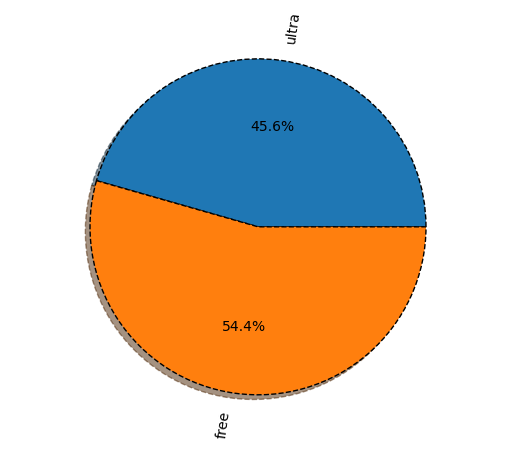

In [28]:
t = users.groupby('subscription_type').size()/len(users['subscription_type'])
t = t.sort_values()
labels = dict(t)
fig, ax = plt.subplots()
ax.pie(t, labels=labels, autopct='%1.1f%%', shadow=True, wedgeprops={'lw':1, 'ls':'--','edgecolor':"k"}, rotatelabels=True)
ax.axis("equal")
plt.show()

**Пользователей с подпиской на 10% меньше, чем пользователей без подписки**

##### Возраст пользователей

In [29]:
t = users.groupby('age').size()
t

age
12      4
13      8
14      9
15     13
16     19
17     26
18     46
19     47
20     71
21     93
22    119
23    129
24    132
25    145
26    131
27    119
28    112
29     68
30     68
31     48
32     41
33     39
34     19
35     15
36      6
37      2
38      3
39      1
43      1
dtype: int64

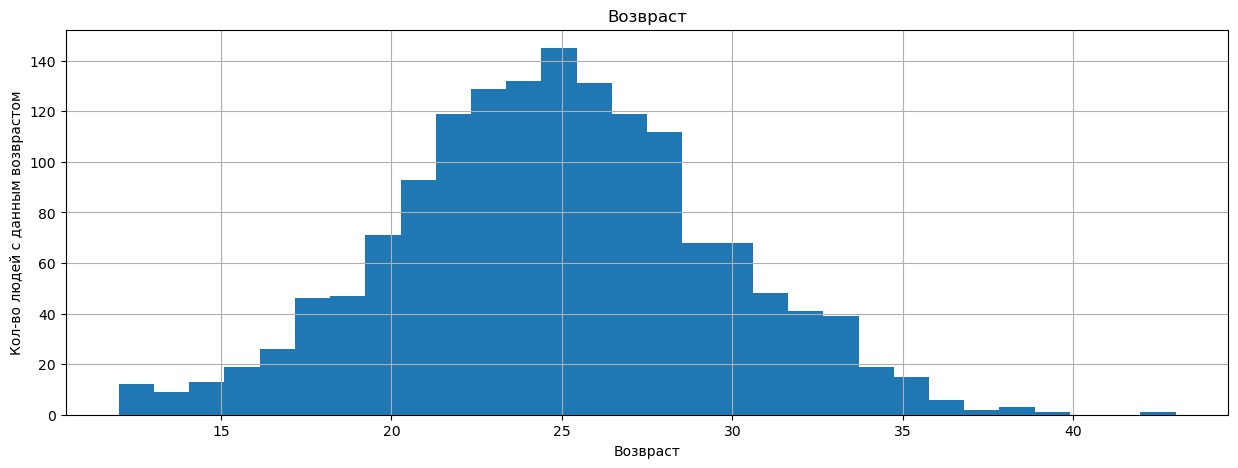

In [30]:
users['age'].hist(bins = len(t)+1 , figsize= (15, 5))
plt.title('Возвраст')
plt.ylabel('Кол-во людей с данным возврастом')
plt.xlabel('Возвраст')
plt.show()

**Видим заметное использование самокатов, категорией людей в возрасте от 20 до 30 лет**

##### Расстояние, которое пользователь преодолел за одну поездку

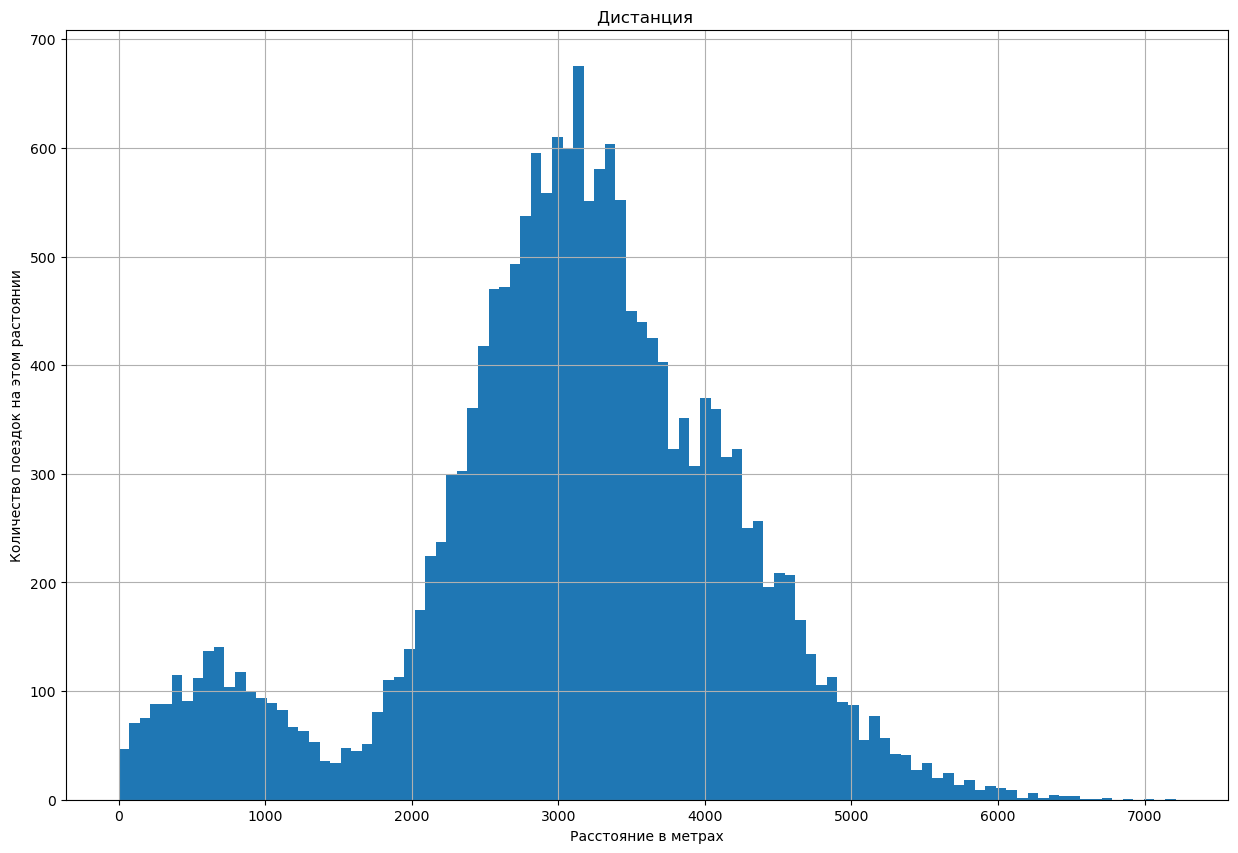

In [31]:
rides['distance'].hist(bins = 100, figsize = (15, 10))
plt.title('Дистанция ')
plt.ylabel('Количество поездок на этом растоянии')
plt.xlabel('Расстояние в метрах')
plt.show()

**На графике видно два пипа активности, на короткие дитснции в районе 600м. И основное использование на расстояние за одну поездку составляет 2 км до 4.5 км**

##### Продолжительность поездок

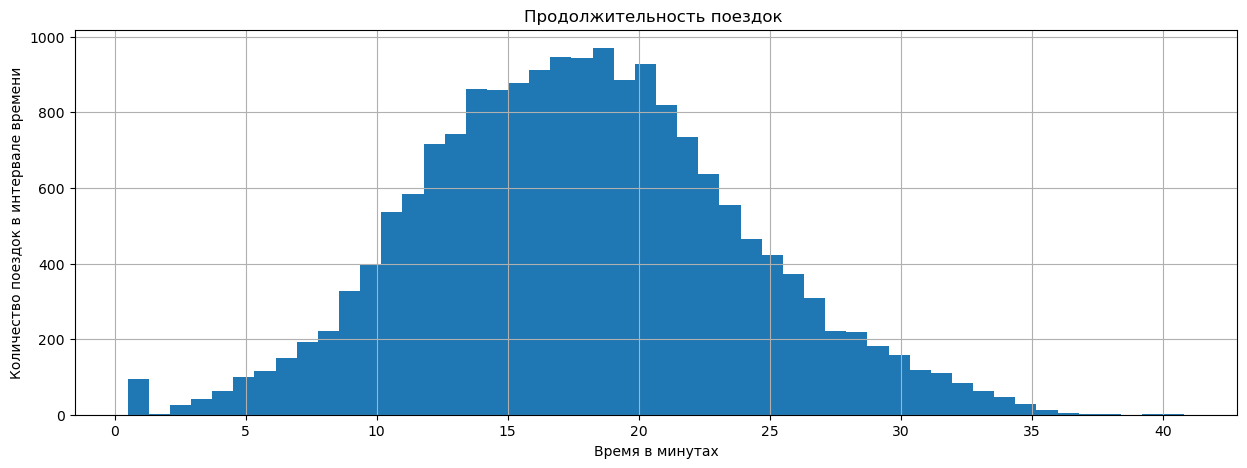

In [32]:
rides['duration'].hist(bins = 50, figsize = (15,5))
plt.title('Продолжительность поездок ')
plt.ylabel('Количество поездок в интервале времени')
plt.xlabel('Время в минутах')
plt.show()

**По граффику можно заметить нормальное распределение. Люди в основном используют самокаты от 10 до 25 минут**

**Вывод:** 
   - По графикам можно предположить, что продолжительность поездки напрямую зависит от дистаниции.
   - В городах почти в одинаковом кол-ве пользуются техникой. 
   - Самокатами в большинстве случаев пользуются люди в возрасте от 20 до 30 лет.
   - Тех кто пользуется самокатами с подпиской и без практичести одинаковое кол-во.

#### Шаг 4. Объединение данных

##### Объедините данные о пользователях, поездках и подписках в один датафрейм. Для этого воспользуйтесь методом merge().

In [33]:
rides['duration'] = np.ceil(rides['duration']) 

In [34]:
users_merge = users.merge(rides, on =  'user_id')
users_merge = users_merge.merge(subscriptions , on = 'subscription_type')
users_merge

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,7.0,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,19.0,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,27.0,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,20.0,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,22.0,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,19.0,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,17.0,2021-11-27,11,8,50,0


In [35]:
users_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int32         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(3)
memory usage: 1.6+ MB


**Создали новую таблицу users_merge из трех таблиц (users, rides, subscriptions) при помощи метода merge() , данные корректно перенеслись и сохранились в новой таблице**

##### Создайте ещё два датафрейма из датафрейма, созданного на этапе 4.1:
- c данными о пользователях без подписки;
- с данными о пользователях с подпиской.

In [36]:
data_sub_ultra = users_merge.loc[users_merge['subscription_type'] == 'ultra']

In [37]:
data_sub_ultra.reset_index(drop = True)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,7.0,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,19.0,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,27.0,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,ultra,3973.046497,25.0,2021-08-29,8,6,0,199
6496,699,Оксана,22,Москва,ultra,3288.702563,16.0,2021-09-12,9,6,0,199
6497,699,Оксана,22,Москва,ultra,3076.159348,15.0,2021-09-26,9,6,0,199
6498,699,Оксана,22,Москва,ultra,4707.845501,16.0,2021-10-17,10,6,0,199


In [38]:
data_sub_free = users_merge.loc[users_merge['subscription_type'] == 'free']

In [39]:
data_sub_free.reset_index(drop = True)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,700,Айдар,22,Омск,free,2515.690719,15.0,2021-01-02,1,8,50,0
1,700,Айдар,22,Омск,free,846.932642,17.0,2021-02-01,2,8,50,0
2,700,Айдар,22,Омск,free,4004.434142,21.0,2021-02-04,2,8,50,0
3,700,Айдар,22,Омск,free,1205.911290,10.0,2021-02-10,2,8,50,0
4,700,Айдар,22,Омск,free,3047.379435,18.0,2021-02-14,2,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11563,1534,Альберт,25,Краснодар,free,3781.098080,20.0,2021-11-04,11,8,50,0
11564,1534,Альберт,25,Краснодар,free,2840.423057,22.0,2021-11-16,11,8,50,0
11565,1534,Альберт,25,Краснодар,free,3826.185507,19.0,2021-11-18,11,8,50,0
11566,1534,Альберт,25,Краснодар,free,2902.308661,17.0,2021-11-27,11,8,50,0


In [40]:
print(len(data_sub_ultra)+len(data_sub_free))
print(len(users_merge)) #потерь в данных нет

18068
18068


**Создали два новых дата фрейма data_sub_free с людьми без подкиски и data_sub_ultra - с подпиской**

##### Визуализируйте информацию о расстоянии и времени поездок для пользователей обеих категорий.

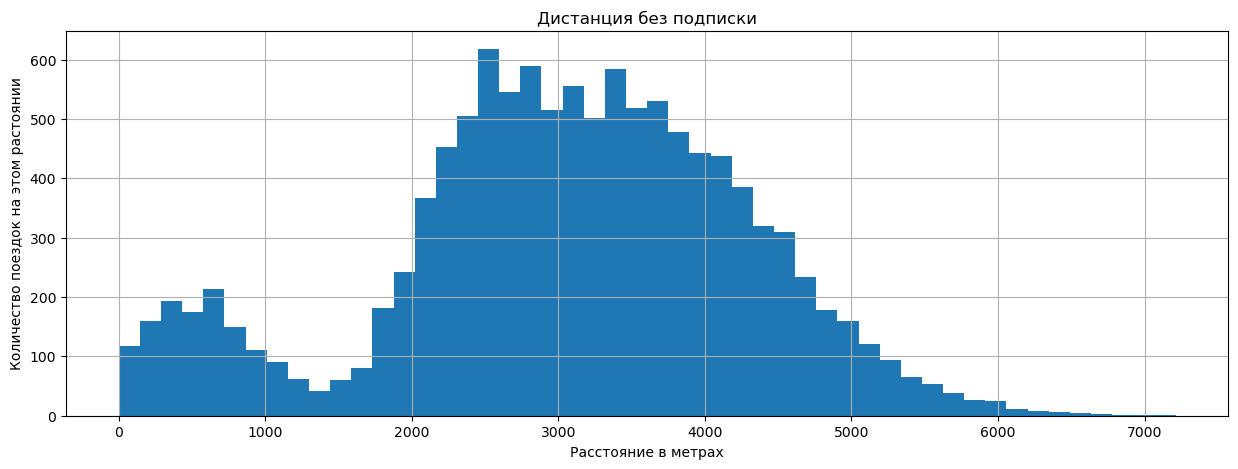

In [41]:
data_sub_free['distance'].hist(bins = 50, figsize = (15,5))
plt.title('Дистанция без подписки')
plt.ylabel('Количество поездок на этом растоянии')
plt.xlabel('Расстояние в метрах')
plt.show()

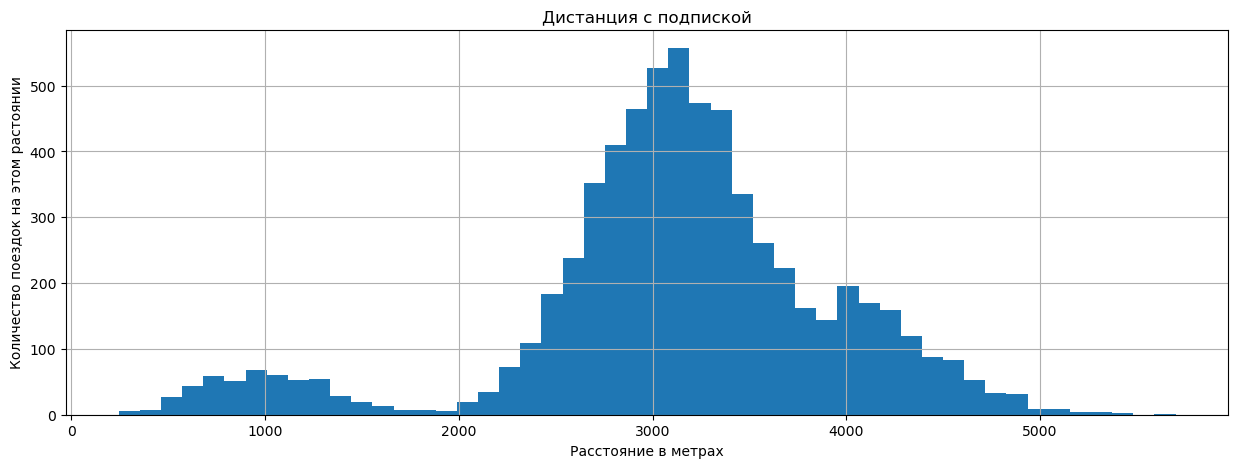

In [42]:
data_sub_ultra['distance'].hist(bins = 50, figsize = (15,5))
plt.title('Дистанция с подпиской')
plt.ylabel('Количество поездок на этом растоянии')
plt.xlabel('Расстояние в метрах')
plt.show()

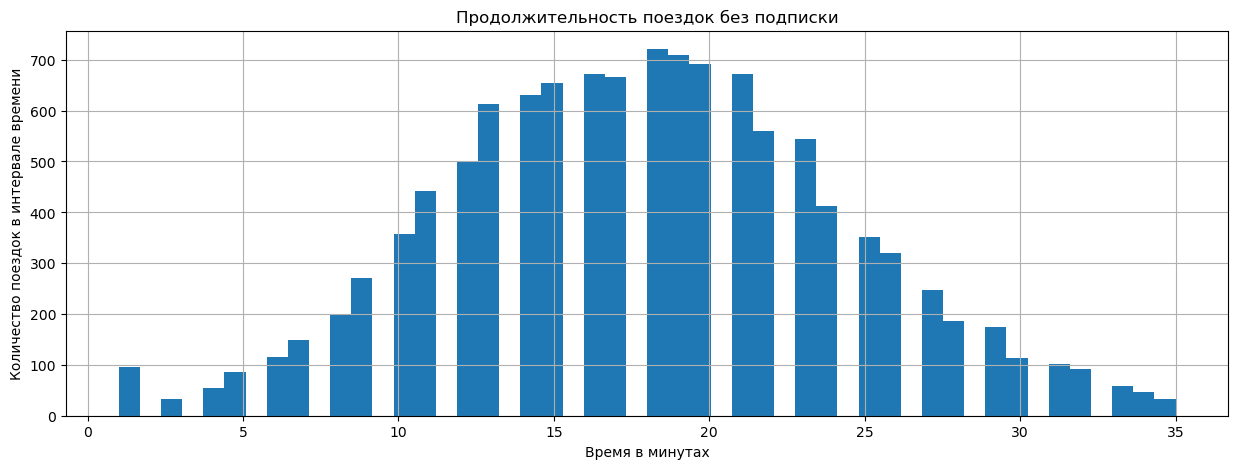

In [43]:
data_sub_free['duration'].hist(bins = 50, figsize = (15,5))
plt.title('Продолжительность поездок без подписки')
plt.ylabel('Количество поездок в интервале времени')
plt.xlabel('Время в минутах')
plt.show()

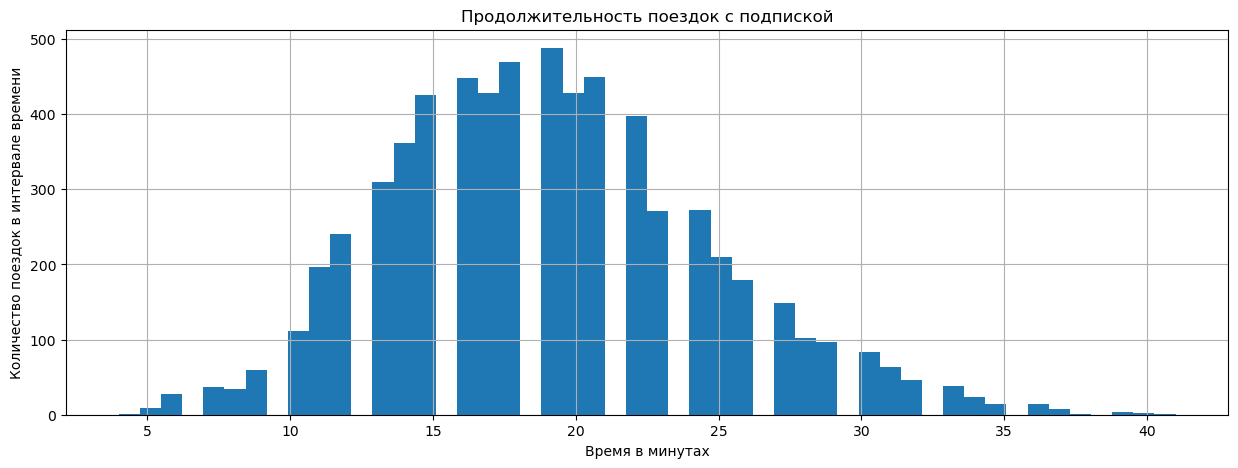

In [44]:
data_sub_ultra['duration'].hist(bins = 50, figsize = (15,5))
plt.title('Продолжительность поездок с подпиской')
plt.ylabel('Количество поездок в интервале времени')
plt.xlabel('Время в минутах')
plt.show()

**Посторили графики для людей имеющих подписку и нет. По растоянию можно заметить разницу в использовании (с подпиской 2.5 км до 4.3 км, без 1.9 км до 4.9 км - еще замечен пик использания на дистанцию до 1 км). По времени анологично с подпиской - 10-27 минут, без подписки 6-29 минут**

#### Шаг 5. Подсчёт выручки

##### Создайте датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдите суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [45]:
users_merge

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,7.0,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,19.0,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,27.0,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,20.0,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,22.0,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,19.0,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,17.0,2021-11-27,11,8,50,0


In [46]:
data_ag = users_merge.groupby(['user_id','month']).agg({'distance': ['sum', 'count'], 'duration': 'sum'}).reset_index()

In [47]:
data_ag.columns = ['_'.join(col).strip() for col in data_ag.columns.values]

In [48]:
data_ag

,user_id_,month_,distance_sum,distance_count,duration_sum
0,1,1,7027.511294,2,42.0
1,1,4,754.159807,1,7.0
2,1,8,6723.470560,2,46.0
3,1,10,5809.911100,2,32.0
4,1,11,7003.499363,3,56.0
...,...,...,...,...,...
11326,1534,6,3409.468534,2,26.0
11327,1534,8,7622.453034,2,48.0
11328,1534,9,4928.173852,1,23.0
11329,1534,11,13350.015305,4,78.0


**После групировки получилась таблица с 11331 строками и 5 столбцами**

##### В этот же датафрейм добавьте столбец с помесячной выручкой, которую принёс каждый пользователь. Для этого обратитесь к информации об условиях оплаты для подписчиков и тех, у кого нет подписки. Продолжительность каждой поездки в каждой строке исходного датафрейма для подсчёта стоимости округляется до следующего целого числа: например, значения 25.3 должны быть преобразованы к 26. 

**Помесячная выручка считается по формуле:** 
- стоимость старта поездки ×  количество поездок + стоимость одной минуты поездки 
× общая продолжительность всех поездок в минутах + стоимость подписки.

In [49]:
data_ag

,user_id_,month_,distance_sum,distance_count,duration_sum
0,1,1,7027.511294,2,42.0
1,1,4,754.159807,1,7.0
2,1,8,6723.470560,2,46.0
3,1,10,5809.911100,2,32.0
4,1,11,7003.499363,3,56.0
...,...,...,...,...,...
11326,1534,6,3409.468534,2,26.0
11327,1534,8,7622.453034,2,48.0
11328,1534,9,4928.173852,1,23.0
11329,1534,11,13350.015305,4,78.0


In [50]:
data_ag['total_price'] = (users_merge['start_ride_price']* data_ag['distance_count']
                          + users_merge['minute_price']* data_ag['duration_sum']
                          + users_merge['subscription_fee'])

In [51]:
data_ag

,user_id_,month_,distance_sum,distance_count,duration_sum,total_price
0,1,1,7027.511294,2,42.0,451.0
1,1,4,754.159807,1,7.0,241.0
2,1,8,6723.470560,2,46.0,475.0
3,1,10,5809.911100,2,32.0,391.0
4,1,11,7003.499363,3,56.0,535.0
...,...,...,...,...,...,...
11326,1534,6,3409.468534,2,26.0,308.0
11327,1534,8,7622.453034,2,48.0,484.0
11328,1534,9,4928.173852,1,23.0,234.0
11329,1534,11,13350.015305,4,78.0,824.0


**Добавили столбец с помесячной выручкой, которую принёс каждый пользователь.**

#### Проверка гипотез 
- Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.

##### Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

**Будем использовать t-критерий Стьюдента, так как сравниваемые выборки независимы между собой.
Гипотеза о равенстве средних двух генеральных совокупностей №1**
 ***Сформулируем гипотезы:***

 - H0: Время затраченное на поездки пользователями тарифов «с подпиской» и «без подписки» не различается
 - H1: Время затраченное на поездки пользователями тарифов «с подпиской» больше времени пользователей «без подписки» 

In [52]:
def delete_outliers(df, column, graphic=0, x = 10, y = 10):
    q1 = df[column].quantile(0.25)                 
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    iqr_test = (df[column] >= (q1 - 1.5 * iqr)) & (df[column] <= (q3 + 1.5 * iqr))
    if graphic == 1:
        return df.loc[iqr_test].boxplot([column], figsize=(x,y))
    else:
        return df.loc[iqr_test] # функция для удаления выбросов

In [53]:
data_sub_ultra_duration = delete_outliers(data_sub_ultra ,'duration', 0 )
data_sub_ultra_duration = data_sub_ultra_duration['duration']
data_sub_ultra_duration

0       26.0
1       16.0
2        7.0
3       19.0
4       27.0
        ... 
6495    25.0
6496    16.0
6497    15.0
6498    16.0
6499    26.0
Name: duration, Length: 6395, dtype: float64

In [54]:
data_sub_free_duration = delete_outliers(data_sub_free , 'duration', 0)
data_sub_free_duration = data_sub_free['duration']
data_sub_free_duration

6500     15.0
6501     17.0
6502     21.0
6503     10.0
6504     18.0
         ... 
18063    20.0
18064    22.0
18065    19.0
18066    17.0
18067    16.0
Name: duration, Length: 11568, dtype: float64

In [55]:
alpha = 0.05

In [56]:
results = st.ttest_ind(data_sub_ultra_duration ,data_sub_free_duration, alternative = 'greater')

In [57]:
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 3.2154245755727334e-22
Отвергаем нулевую гипотезу


In [58]:
data_sub_ultra_duration.mean()

18.786864738076623

In [59]:
data_sub_free_duration.mean()

17.890992392807746

**Пользователи с подпиской действительно тратят время на поездки больше, значит пользователи с подпиской выгоднее компании**

##### Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы.

***Сформулируем гипотезы:***

 - H0: Cредняя расстояние одной поездки, которое проезжают пользователи с подпиской за одну поездку равно 3130
 - H1: Cредняя расстояние одной поездки, которое проезжают пользователи с подпиской за одну поездку больше 3130

In [60]:
# код ревьюера
data_sub_ultra

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,7.0,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,19.0,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,27.0,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,ultra,3973.046497,25.0,2021-08-29,8,6,0,199
6496,699,Оксана,22,Москва,ultra,3288.702563,16.0,2021-09-12,9,6,0,199
6497,699,Оксана,22,Москва,ultra,3076.159348,15.0,2021-09-26,9,6,0,199
6498,699,Оксана,22,Москва,ultra,4707.845501,16.0,2021-10-17,10,6,0,199


In [61]:
data_sub_ultra_distance = data_sub_ultra['distance']
data_sub_ultra_distance

0       4409.919140
1       2617.592153
2        754.159807
3       2694.783254
4       4028.687306
           ...     
6495    3973.046497
6496    3288.702563
6497    3076.159348
6498    4707.845501
6499    3202.890770
Name: distance, Length: 6500, dtype: float64

In [62]:
alpha = .05

In [63]:
data_sub_ultra_distance_value = 3130

In [64]:
results = st.ttest_1samp(
    data_sub_ultra_distance, 
    data_sub_ultra_distance_value,
      alternative='greater')

In [65]:
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 


p-значение: 0.9195368847849785
Не отвергаем нулевую гипотезу


In [66]:
data_sub_ultra_distance.mean()

3115.4453880370247

**Вывод:** Пользователи с подпиской в среднем проезжают дистанцию меньше , чем 3130 м, из этого следует, что самокаты в большинстве случеев не подвергаются износу.

##### Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.

***Сформулируем гипотезы:***

 - H0: Cредняя помесячная выручка от пользователей с подпиской по месяцам и без одинакова  
 - H1: Cредняя помесячная выручка от пользователей с подпиской по месяцам больше чем вырочка без подписки  

In [67]:
data_ag['subscription_type'] = users_merge['subscription_type']
data_ag# добавили в таблицу data_ag столбец с типом подписки

,user_id_,month_,distance_sum,distance_count,duration_sum,total_price,subscription_type
0,1,1,7027.511294,2,42.0,451.0,ultra
1,1,4,754.159807,1,7.0,241.0,ultra
2,1,8,6723.470560,2,46.0,475.0,ultra
3,1,10,5809.911100,2,32.0,391.0,ultra
4,1,11,7003.499363,3,56.0,535.0,ultra
...,...,...,...,...,...,...,...
11326,1534,6,3409.468534,2,26.0,308.0,free
11327,1534,8,7622.453034,2,48.0,484.0,free
11328,1534,9,4928.173852,1,23.0,234.0,free
11329,1534,11,13350.015305,4,78.0,824.0,free


In [68]:
data_sub_ultra_price = data_ag.loc[data_ag['subscription_type'] == 'ultra']['total_price']
data_sub_ultra_price

0       451.0
1       241.0
2       475.0
3       391.0
4       535.0
        ...  
6495    583.0
6496    349.0
6497    457.0
6498    451.0
6499    253.0
Name: total_price, Length: 6500, dtype: float64

In [69]:
data_sub_free_price = data_ag.loc[data_ag['subscription_type'] == 'free']['total_price']
data_sub_free_price

6500     614.0
6501     856.0
6502     476.0
6503      82.0
6504     186.0
         ...  
11326    308.0
11327    484.0
11328    234.0
11329    824.0
11330    178.0
Name: total_price, Length: 4831, dtype: float64

In [70]:
alpha = .05

In [71]:
results = st.ttest_ind(data_sub_ultra_price ,data_sub_free_price, alternative = 'greater')

In [72]:
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.318341752391833e-51
Отвергаем нулевую гипотезу


In [73]:
data_sub_ultra_price.mean()

368.6763076923077

In [74]:
data_sub_free_price.mean()

328.34527013040776

**Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Это значит, что бизнесу это выгодно. И в этом случае можно увеличить стоимость старта для людей без подписки**

##### Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Для проверки этой гипотезы потребуется двухвыборочный t-тест для зависимых выборок. При двух выборках **df1** и **df2** ,с **alpha = 0.05** и с провосторонней альтернативной гипотезой. **result= st.ttest_les(df1,df2, alternative = 'greater')** 

 При 
 - **print('p-значение:', results.pvalue)**
 - **if (results.pvalue < alpha):**
 -   **print("Отвергаем нулевую гипотезу")**
 - **else:**
 -   **print("Не получилось отвергнуть нулевую гипотезу")**
 
Этот код проверяет одностороннюю гипотезу: о том, что до изменения (первая выборка) среднее значение переменной в генеральной совокупности было больше, чем после изменения вторая выборка). Метод принимает на вход только выборки одинакового размера.

**Вывод:** 
  - ***Пользователи с подпиской действительно тратят время на поездки больше, значит пользователи с подпиской выгоднее компании***
  - ***Пользователи с подпиской в среднем проезжают дистанцию больше, чем 3130 м, из этого следует, что самокаты быстрее износятся***
  - ***Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Это значит, что бизнесу это выгодно***
  
**Предложение для бизнеса:**
 - Чтобы окупать износостойкость самокатов, можно ввести ограничение по дистанции, если дистанция превышает 3 км добавить к цене за минуту ~2 р.
 - Чтобы как-то сгладить разницу в помесячной выручке, нужно либо увеличить стартовую цену или цену за минуту пользователям без подписки. Или быть более лояльными к пользователям с подпиский и снизить стоимость подписки.
 - С уменьшением стоимости подписки, привлечем больше потенциальных пользователей, что увеличит прибыль.  

#### Шаг 7. Распределения

##### Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 

***Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10% пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.***

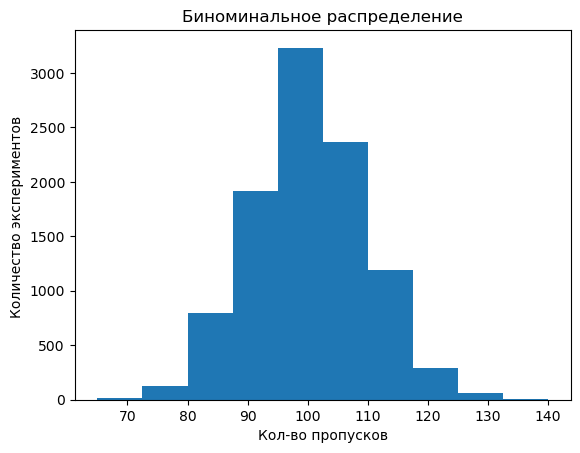

In [75]:
import matplotlib.pyplot as plt
import scipy.stats as stats

binom_sim = data = stats.binom.rvs(n = 1000, p =0.1, size = 10000)
plt.hist(binom_sim, bins = 10, density = False)
plt.title('Биноминальное распределение')
plt.ylabel('Количество экспериментов ')
plt.xlabel('Кол-во пропусков')
plt.show()

**На графике видно, что примено 50 % набрать 100 новых клиентов , которые захотят продлить эту подписку.**

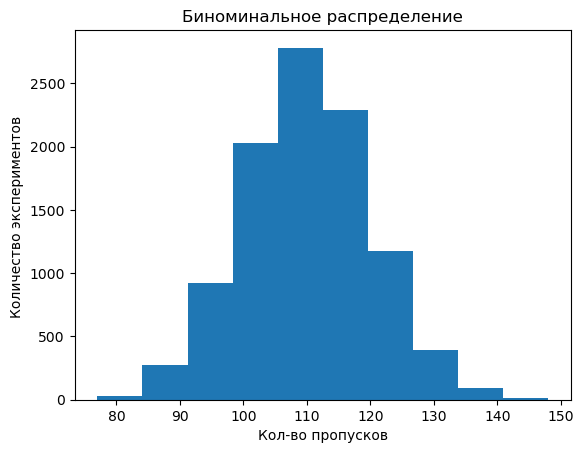

In [76]:
binom_sim = data = stats.binom.rvs(n = 1100, p =0.1, size = 10000)
plt.hist(binom_sim, bins = 10, density = False)
plt.title('Биноминальное распределение')
plt.ylabel('Количество экспериментов ')
plt.xlabel('Кол-во пропусков')
plt.show()

**На графике видно, что примено 20 % не набрать 100 новых клиентов, которые захотят продлить эту подписку. И этого нам все равно мало**

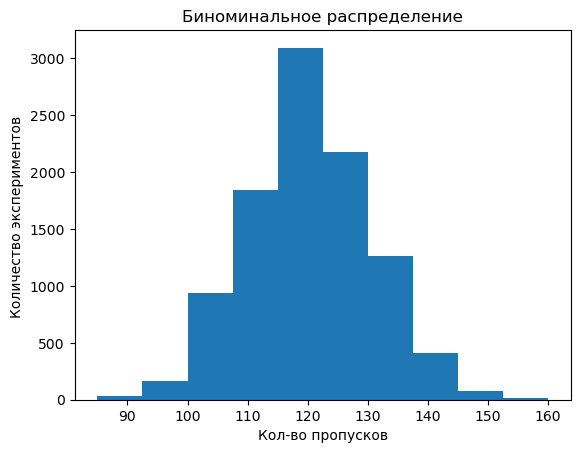

In [77]:
binom_sim = data = stats.binom.rvs(n = 1200, p =0.1, size = 10000)
plt.hist(binom_sim, bins = 10, density = False)
plt.title('Биноминальное распределение')
plt.ylabel('Количество экспериментов ')
plt.xlabel('Кол-во пропусков')
plt.show()

**На графике видно, что примено 5 % не набрать 100 новых клиентов, которые захотят продлить эту подписку. Будем работать со значением в 1200 промокодов на один бесплатный месяц подписки**

In [78]:
n = 1200
p = 0.1
mu = n*p
sigma = np.sqrt(n*p*(1-p))
distr = st.norm(mu, sigma)
x = 100

# считаем вероятность получить значение меньше x
result = distr.cdf(x)
print(result)

0.027145914183427298


**При количестве 1200 промокодов  вероятность не выполнить план равно 2,71 %. Значит можем проверить для меньшего кол-ва промокодов примено для 1170**

In [79]:
n = 1170
p = 0.1
mu = n*p
sigma = np.sqrt(n*p*(1-p))
distr = st.norm(mu, sigma)
x = 100

# считаем вероятность получить значение меньше x
result = distr.cdf(x)
print(result)

0.04879359652776027


In [80]:
#Код ревьюера

st.binom(2, 0.5).cdf(1)

0.75

**При количестве 1170 промокодов вероятность не выполнить план равно 4.88 % что примерно равно 5 %. Что от нас и требовалось.**

**Вывод:**

**То есть по завершении периода действия подписки можно с уверенность в 95% сказать, что 100 пользователей продлят подписку, если количество промокодов будет не ниже 1170**